In [1]:
from torch.utils.data import DataLoader

from faim_dl.data_record import DefaultDataRecord
from faim_dl.dataset import ZarrDataset

import gunpowder as gp

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import math
import numpy as np

In [2]:
from faim_dl.segmentation.unet_three_class.UNet3Class import UNet

In [3]:
datarecord = DefaultDataRecord.deserialize('./dataset/BBBC039.zarr/BBBC039_rdf.json')

In [4]:
datarecord.attachments

{'train_data': {'data': './train_data', 'histogram': './train_data_hist.npz'},
 'val_data': {'data': './val_data', 'histogram': './val_data_hist.npz'},
 'test_data': {'data': './test_data', 'histogram': './test_data_hist.npz'}}

In [5]:
def add_unknown(data, ratio=0.5):
    mask = np.random.uniform(size=data.shape) < ratio
    data_ = data.copy()
    data_[mask] = -1
    return data_

In [6]:
from skimage.segmentation import find_boundaries
import numpy as np

def convert_to_onehot(data):
    boundaries = find_boundaries(np.maximum(0, data[0]), mode='outer')
    three_classes = (data[0] > 0).astype(np.int16)
    three_classes[boundaries] = 2

    one_hot = np.zeros_like(three_classes, shape=(4,) + three_classes.shape)
    one_hot[0, three_classes == 0] = 1
    one_hot[1, three_classes == 1] = 1
    one_hot[2, three_classes == 2] = 1
    one_hot[3, data[0] != -1] = 1
    return one_hot

In [7]:
test = lambda data: convert_to_onehot(add_unknown(data))

In [8]:
train_hist = datarecord.histograms['train_data']
train_ds = ZarrDataset('./dataset/BBBC039.zarr', 
                 dataset_name='train_data', 
                 target_name='nuclei',
                 random_location=True,
                 simple_augment=True,
                 elastic_augment={"control_point_spacing": (16, 16),
                                  "jitter_sigma": (1.5, 1.5),
                                  "rotation_interval": (0, math.pi / 2),
                                  "scale_interval": (0.9, 1.1)},
                 intensity_augment={"scale_min": 0.9,
                                    "scale_max": 1.1,
                                    "shift_min": -0.1,
                                    "shift_max": 0.1},
                 noise_augment={"mean": 0, "min_var": 0.05, "max_var": 0.001},
                 shape=(128,128),
                 normalization_mi_ma=(train_hist.quantile(0.03), train_hist.quantile(0.998)),
                      target_transformation=convert_to_onehot, 
                      oversample=10)

val_hist = datarecord.histograms['val_data']
val_ds = ZarrDataset('./dataset/BBBC039.zarr', 
                 dataset_name='val_data', 
                 target_name='nuclei',
                 random_location=True,
                 simple_augment=True,
                 elastic_augment={"control_point_spacing": (16, 16),
                                  "jitter_sigma": (1.5, 1.5),
                                  "rotation_interval": (0, math.pi / 2),
                                  "scale_interval": (0.9, 1.1)},
                 intensity_augment={"scale_min": 0.9,
                                    "scale_max": 1.1,
                                    "shift_min": -0.1,
                                    "shift_max": 0.1},
                 noise_augment={"mean": 0, "min_var": 0.05, "max_var": 0.001},
                 shape=(128,128),
                 normalization_mi_ma=(val_hist.quantile(0.03), val_hist.quantile(0.998)),
                      target_transformation=convert_to_onehot)

In [9]:
train_dl = DataLoader(train_ds, batch_size=20, num_workers=12, pin_memory=True, persistent_workers=True)
val_dl = DataLoader(val_ds, batch_size=20, num_workers=12, pin_memory=True, persistent_workers=True)

In [10]:
model = UNet(in_channels=1, out_channels=3, depth=2)

In [11]:
from composer import Trainer
from composer.algorithms import BlurPool, LabelSmoothing, SAM, SelectiveBackprop
from composer.optim.scheduler import CosineAnnealingWithWarmupScheduler
from composer.loggers import WandBLogger
from composer.callbacks import LRMonitor

In [12]:
import torch

In [13]:
from faim_dl.segmentation.unet_three_class import SaveBestCheckpoint

In [14]:
from composer import Callback, State, Logger

In [15]:
import wandb

In [16]:
class ImageLogger(WandBLogger):
    
    def eval_after_forward(self, state: State, logger: Logger):
        if state.timer.get_timestamp().batch_in_epoch.value == 0:
            img = state.batch[0][:3,0].detach().cpu().numpy()
            target = state.batch[1][:3,1].detach().cpu().numpy()
            pred = torch.softmax(state.outputs[:3].detach(), dim=1)[:, 1].cpu().numpy()
            
            img = (img - img.min())*255/(img.max() - img.min())
            target = (target - target.min())*255/(target.max() - target.min())
            pred = (pred - pred.min())*255/(pred.max() - pred.min())
            
            raw = [wandb.Image(i, mode='L') for i in img]
            target = [wandb.Image(t, mode='L') for t in target]
            pred = [wandb.Image(p, mode='L') for p in pred]
            wandb.log({"Input": raw, "Target": target, "Prediction": pred}, step=int(state.timer.get_timestamp().batch))

In [17]:
trainer = Trainer(model=model,
                  train_dataloader=train_dl,
                  eval_dataloader=val_dl,
                  optimizers=torch.optim.Adam(model.parameters(), lr=0.0004),
                  schedulers=CosineAnnealingWithWarmupScheduler(t_warmup='0.05dur'),
                  max_duration=20,
                 device='gpu',
                 algorithms=[BlurPool(replace_convs=True,
                        replace_maxpools=True)],
                 loggers=[ImageLogger(init_params={"project":"faim-dl", "entity":"tibuch"})])

trainer.fit()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tibuch (use `wandb login --relogin` to force relogin)


/Event.INIT,▁
blurpool/num_blurconv_layers,▁
blurpool/num_blurpool_layers,▁
dice/val,▁▆▇▆▇▇▇▆▇▆▇████▇▇███
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss/train,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/batch_idx,▂▆▁▅▁▅▂▆▂▆▁▅▂▆▂▆▂▇▃▇▂▆▂▇▃▇▃▇▄█▃▇▃▇▄█▄█▃▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
/Event.INIT,1
blurpool/num_blurconv_layers,4
blurpool/num_blurpool_layers,0


In [21]:
model.load_state_dict(torch.load('./models/best_model')["state"]["model"], strict=False)

_IncompatibleKeys(missing_keys=['train_loss.cross_entropy.weight'], unexpected_keys=[])

In [22]:
from skimage.io import imread

In [23]:
img = imread('/home/tibuch/Data/broad/nuclei_U2OS/images/IXMtest_B02_s9_w124B5080D-EBE1-47D2-B147-C0F342039EDF.tif')

In [24]:
mi, ma = np.quantile(img, [0.03, 0.998])

In [25]:
img = (img - mi)/(ma- mi)

In [26]:
with torch.no_grad():
    model = model.eval()
    pred = model.module(torch.from_numpy(img[np.newaxis, np.newaxis].astype(np.float32)).cuda()).detach().cpu()

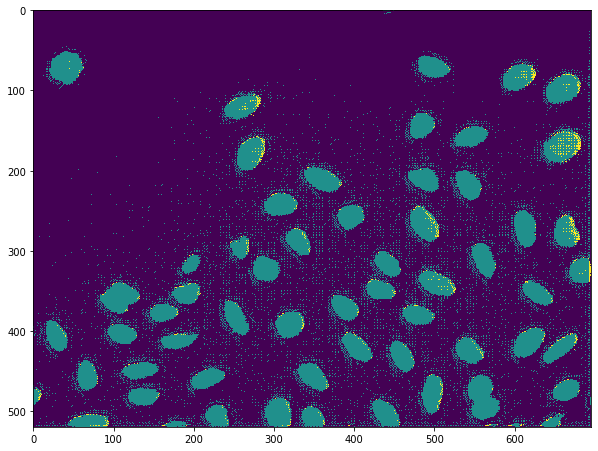

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(np.argmax(pred[0], 0), interpolation='nearest')